In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 64.7 MB/s eta 0:00:00


# Import lib

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import LayerNorm
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModel, AutoTokenizer, AdamW, get_cosine_schedule_with_warmup
import numpy as np
import os
import time
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
import re
import copy
import nltk
from nltk.tokenize import word_tokenize
import math
from torchinfo import summary
from google.colab import drive
from tqdm.auto import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Import dataset

In [ ]:
! git clone https://github.com/duongnghia222/News_classification

Cloning into 'News_classification'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 468 (delta 34), reused 46 (delta 18), pack-reused 402
Receiving objects: 100% (468/468), 104.72 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (272/272), done.
Updating files: 100% (55/55), done.


In [ ]:
# Load data from CSV file
df = pd.read_csv('News_classification/data/raw_data/raw_data.csv', encoding='utf-8-sig')

# Visualize Data

In [ ]:
df.tail()

,Content,Label
10391,"Một cá nhân bất ngờ mua vào 30,77 triệu cổ phi...",TTF
10392,"Chưa kịp bán ra, Chủ tịch Đỗ Quý Hải tiếp tục ...",HPX
10393,POM cho cán bộ nhân viên nghỉ việc vì dừng lò ...,POM
10394,Năm Bảy Bảy (NBB) chấp thuận cho Công ty con c...,NBB
10395,Chứng khoán Ngân hàng Sài Gòn Thương Tín (SBS)...,SBS


In [ ]:
# Count the number of words in each article's content and number of times a class appear
df['Word Count'] = df['Content'].apply(lambda x: len(str(x).split()))
df['Class Count'] = df.groupby('Label')['Label'].transform('count')

# Calculate statistics for word count
df['Word Count'].describe()

count    10396.000000
mean       607.325414
std        352.123889
min         46.000000
25%        381.000000
50%        514.000000
75%        725.250000
max       4235.000000
Name: Word Count, dtype: float64

In [ ]:
df.head()

,Content,Label,Word Count,Class Count
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC,599,108
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG,642,65
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC,577,108
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV,430,3
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG,1247,197


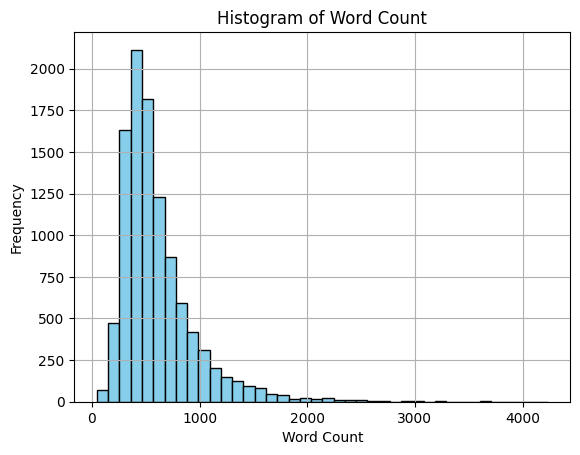

In [ ]:
# Plot histogram for word count
plt.hist(df['Word Count'], bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Count the occurrence of each unique label
label_counts = df['Label'].value_counts()
print(label_counts.describe())

# Loop over each unique label and print its count
# for label, count in label_counts.items():
#     print(f"Label: {label}, Count: {count}")

count    927.000000
mean      11.214671
std       21.224713
min        1.000000
25%        1.000000
50%        3.000000
75%       11.000000
max      197.000000
Name: Label, dtype: float64


## Extract Dataset

In [ ]:
# extracted_df
e_df = df.loc[df['Class Count'] > 17].sort_values(by="Class Count", ascending=False)
e_df.count()

Content        7256
Label          7256
Word Count     7256
Class Count    7256
dtype: int64

In [ ]:
number_of_classes = e_df['Label'].nunique()
number_of_classes

156

# Processing Dataset

## Clean text

In [ ]:
with open('/content/News_classification/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

vietnamese_stopwords[:10]

['a lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy']

In [ ]:
def clean_text(txt):
    txt = re.sub('\s+', ' ', txt)
    txt = txt.replace('.','')
    txt = re.sub('\n', ' ', txt)
    txt = [word_tokenize(wrd) for wrd in txt.split() if wrd not in vietnamese_stopwords]
    txt = [item[0] for item in txt]
    txt = ' '.join(txt)
    return txt

clean_text(" VinFast chính thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S tại 24 tỉnh, thành phố trên cả nước")

'VinFast thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S 24 tỉnh thành phố'

In [ ]:
# e_df['Content'] = e_df['Content'].apply(clean_text)
e_df.head()

,Content,Label,Word Count,Class Count
979,Hòa Phát muốn đầu tư loạt dự án rộng hơn 1.500...,HPG,950,197
3878,Hòa Phát muốn rót 85.000 tỷ đồng để mở rộng Kh...,HPG,425,197
1256,Hòa Phát lên lịch tổ chức đại hội cổ đông 2022...,HPG,598,197
3787,Hòa Phát đã khắc phục xong sự cố hỏa hoạn tại ...,HPG,271,197
3771,Hòa Phát tiết kiệm 1.700 tỷ đồng trong 6 tháng...,HPG,601,197


## Transform labels

In [ ]:
labels_list = e_df['Label'].tolist()
print(labels_list[:10])

['HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG']


In [ ]:
le = LabelEncoder()
labels = le.fit_transform(labels_list).tolist()
print(labels[-10:])

[142, 31, 142, 128, 90, 73, 101, 90, 90, 142]


In [ ]:
e_df['Encode Label'] = labels
e_df.head(10)

,Content,Label,Word Count,Class Count,Encode Label
979,Hòa Phát muốn đầu tư loạt dự án rộng hơn 1.500...,HPG,950,197,55
3878,Hòa Phát muốn rót 85.000 tỷ đồng để mở rộng Kh...,HPG,425,197,55
1256,Hòa Phát lên lịch tổ chức đại hội cổ đông 2022...,HPG,598,197,55
3787,Hòa Phát đã khắc phục xong sự cố hỏa hoạn tại ...,HPG,271,197,55
3771,Hòa Phát tiết kiệm 1.700 tỷ đồng trong 6 tháng...,HPG,601,197,55
1278,Tham vọng làm dự án thép công suất 80% Hoà Phá...,HPG,1135,197,55
1287,Những doanh nhân tuổi Sửu nổi bật trên thương ...,HPG,1253,197,55
3725,"Hòa Phát lãi kỷ lục, ban lãnh đạo sắp được thư...",HPG,573,197,55
3685,"Ông Nguyễn Việt Thắng, tân Tổng Giám đốc Tập đ...",HPG,135,197,55
7763,Hòa Phát đã bán 530 ngàn tấn thép trong tháng ...,HPG,303,197,55


## Split trainset valset

In [ ]:
trainset, valset = train_test_split(e_df, test_size=0.1, stratify=e_df['Encode Label'])
print(len(trainset))
trainset = trainset.drop_duplicates(subset=['Label', 'Word Count'], keep='first')
print(len(trainset))
trainset['Class Count'] = trainset.groupby('Label')['Label'].transform('count')
valset['Class Count'] = valset.groupby('Label')['Label'].transform('count')
print("Number of unique labels in the trainset", trainset['Encode Label'].nunique())
print("Number of unique labels in the valset", valset['Encode Label'].nunique())

6530
6107
Number of unique labels in the trainset 156
Number of unique labels in the valset 156


In [ ]:
trainset_unique_label = trainset.drop_duplicates(subset='Encode Label').sort_values(by="Class Count")
trainset_unique_label.head()


,Content,Label,Word Count,Class Count,Encode Label
9641,One Capital Hospitality (OCH): Quản lý quỹ Lea...,OCH,495,14,90
2290,Lợi nhuận quý II của Vinatex tăng 49% nhờ dự t...,VGT,553,15,142
3700,"Tổng Công ty Tín Nghĩa đẩy mạnh tái cơ cấu, th...",TID,1151,15,131
7200,POM chuyển từ lãi sang lỗ sau soát xét. Theo B...,POM,288,16,101
7051,"L14 kỳ vọng lãi 2023 tăng 32%, giảm tỷ lệ cổ t...",L14,685,16,73


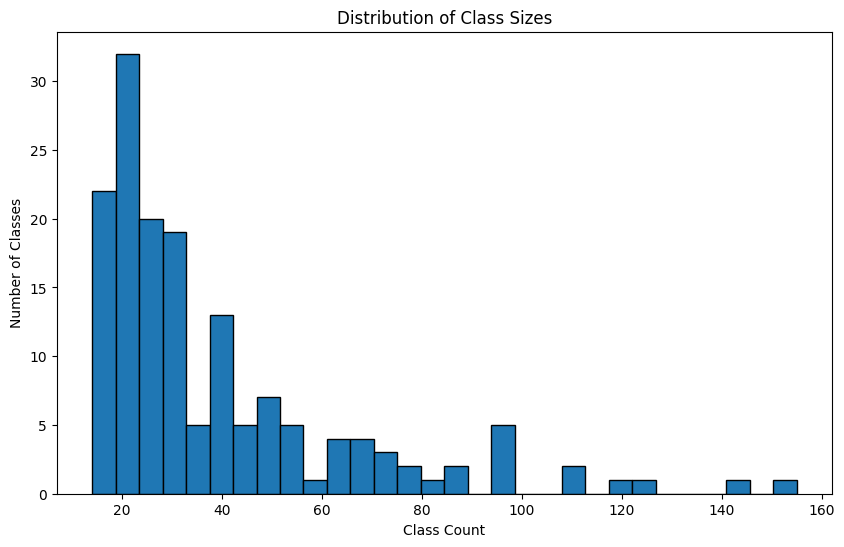

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(trainset_unique_label['Class Count'], bins=30, edgecolor='black')
plt.title('Distribution of Class Sizes')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()


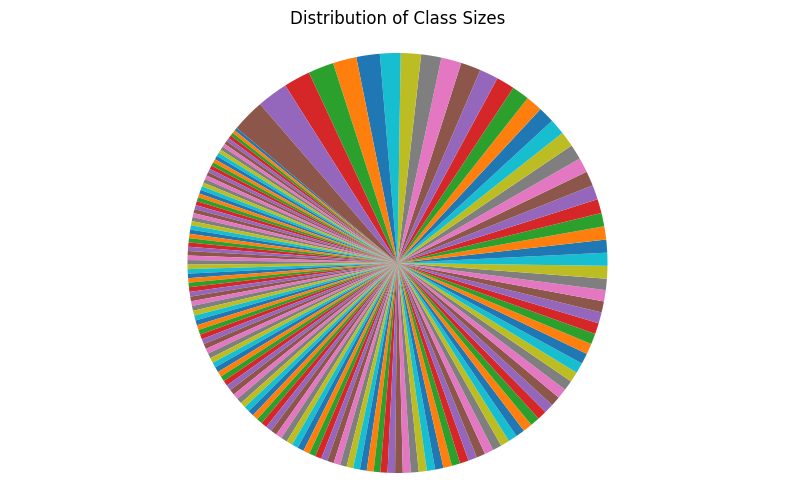

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = trainset_unique_label['Class Count'].values

plt.figure(figsize=(10,6))
plt.pie(sizes, startangle=140)
plt.title('Distribution of Class Sizes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Balance Dataset

In [ ]:
def balance_data(df, target_count):
    new_data = pd.DataFrame(columns=df.columns)
    for label in df['Label'].unique():
        label_df = df[df['Label'] == label]
        count = len(label_df)
        additional_samples = []

        if count < 20:
            for _, row in label_df.iterrows():
                content = row['Content']
                sentences = nltk.tokenize.sent_tokenize(content)[:3]
                for sentence in sentences:
                    new_sample = pd.Series(data=row.values, index=df.columns)
                    new_sample['Content'] = sentence
                    new_sample['Word Count'] = len(sentence.split())
                    if new_sample['Word Count'] > 3:
                      additional_samples.append(new_sample)

        elif 20 <= count < 45:
            for _, row in label_df.iterrows():
                content = row['Content']
                sentences = nltk.tokenize.sent_tokenize(content)[:2]
                for sentence in sentences:
                    new_sample = pd.Series(data=row.values, index=df.columns)
                    new_sample['Content'] = sentence
                    new_sample['Word Count'] = len(sentence.split())
                    if new_sample['Word Count'] > 3:
                      additional_samples.append(new_sample)

        else:  # count >= 45
            for _, row in label_df.iterrows():
                content = row['Content']
                sentences = nltk.tokenize.sent_tokenize(content)
                if len(sentences) > 1:
                    sentence = sentences[1]  # Take only 2nd sentence if it exists
                    new_sample = pd.Series(data=row.values, index=df.columns)
                    new_sample['Content'] = sentence
                    new_sample['Word Count'] = len(sentence.split())
                    if new_sample['Word Count'] > 3:
                      additional_samples.append(new_sample)

        # This is a new block of code to limit the number of samples
        # We randomly select 'target_count' samples if there are more than 'target_count' samples
        if len(additional_samples) > target_count:
            additional_samples = random.sample(additional_samples, target_count)

        additional_samples = pd.DataFrame(additional_samples)
        new_data = pd.concat([new_data, additional_samples], ignore_index=True)

    return new_data


In [ ]:
balanced_trainset = balance_data(trainset, target_count=60)
len(balanced_trainset)

8324

In [ ]:
balanced_valset = balance_data(valset, target_count=60)
len(balanced_valset)

2145

In [ ]:
balanced_trainset['Class Count'] = balanced_trainset.groupby('Label')['Label'].transform('count')
balanced_trainset.head(10)

,Content,Label,Word Count,Class Count,Encode Label
0,Bà Phạm Thị Thanh Mai làm Chủ tịch Hội đồng qu...,FLC,29,60,35
1,Cục thuế TP Hà Nội cho biết Tập đoàn FLC có số...,FLC,21,60,35
2,Doanh thu hợp nhất về bán hàng và cung cấp dịc...,FLC,42,60,35
3,HĐQT Tập đoàn FLC (HOSE: FLC) vừa chấp thuận đ...,FLC,41,60,35
4,Cơ quan Cảnh sát điều tra Bộ Công an cho rằng ...,FLC,43,60,35
5,"Kể từ ngày 1/1/2023, vị trí này được chuyển gi...",FLC,62,60,35
6,"Ông Đặng Tất Thắng, cựu Chủ tịch FLC, cựu CEO ...",FLC,37,60,35
7,Sau gần một tháng ngồi ghế Phó Chủ tịch HĐQT l...,FLC,27,60,35
8,Công ty Đấu giá Hợp danh Minh Pháp cho biết bu...,FLC,38,60,35
9,UBCKNN phạt tiền Công ty CP Tập đoàn FLC 100 t...,FLC,49,60,35


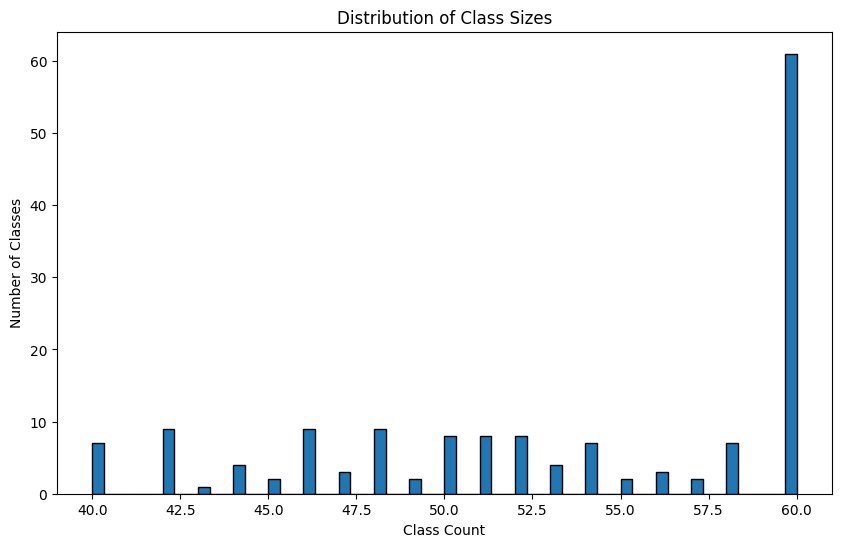

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(balanced_trainset.drop_duplicates(subset='Encode Label').sort_values(by="Class Count")['Class Count'], bins=60, edgecolor='black')
plt.title('Distribution of Class Sizes')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()

# Load phoBERT tokenizer

In [ ]:
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
text = "công tyNếu tính GJK"
print(tokenizer.encode(text))
text = "công ty Nếu tính gjk"
print(tokenizer.encode(text))

[0, 675, 6745, 313, 294, 1276, 2136, 2260, 2]
[0, 675, 6892, 313, 294, 1529, 57202, 2]


# Hyperparameters


In [ ]:
MAX_LENGTH = 256  # Adjust as needed
BATCH_SIZE = 32
N_CLASSES = number_of_classes  # Replace with your actual number of classes
EPOCHS = 30

# ArticleDataset Class

In [ ]:
class ArticleDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length=256):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = item.get('Encode Label')
        encoding = self.tokenizer.encode_plus(
            text=item.Content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'content': item.Content,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [ ]:
x = torch.tensor([1, 2, 3, 4, 5])
print(x.shape)

torch.Size([5])


In [ ]:
a_ds = ArticleDataset(balanced_trainset, labels, tokenizer, MAX_LENGTH)
random_index = random.randint(0, len(a_ds) - 1)  # Generate a random index within the valid range
sample_item = a_ds[random_index]
print(len(a_ds))
print(sample_item.keys())
print(sample_item['content'])

8324
dict_keys(['content', 'input_ids', 'attention_mask', 'labels'])
Trong đó, biên lợi nhuận gộp giảm từ 17,4% về còn 16,1%.Trong kỳ, lợi nhuận gộp giảm 82,7% so với cùng kỳ, tương ứng giảm 201,67 tỷ đồng về 42,2 tỷ đồng; doanh thu tài chính tăng 202,5%, tương ứng tăng thêm 55,79 tỷ đồng lên 83,34 tỷ đồng; chi phí tài chính tăng 181,3%, tương ứng tăng thêm 45,98 tỷ đồng lên 71,34 tỷ đồng; chi phí bán hàng và quản lý doanh nghiệp giảm 55,3%, tương ứng giảm 39,28 tỷ đồng về 31,8 tỷ đồng và các hoạt động khác biến động không đáng kể.Lũy kế trong năm 2022, GILimex ghi nhận doanh thu đạt 3.166,6 tỷ đồng, giảm 23,7% so với cùng kỳ và lợi nhuận sau thuế ghi nhận 361,43 tỷ đồng, tăng nhẹ 9,3% so với cùng kỳ năm trước.Xét về hoạt động kinh doanh cốt lõi (lợi nhuận gộp – chi phí tài chính – chi phí bán hàng & quản lý doanh nghiệp), trong năm 2022, Công ty ghi nhận lợi nhuận cốt lõi giảm 96,7% so với cùng kỳ, tương ứng giảm 366,84 tỷ đồng về 12,4 tỷ đồng.Như vậy, năm 2022, hoạt động kinh doanh c

In [ ]:
print(sample_item["input_ids"].shape)
print(tokenizer.decode(sample_item['input_ids']))
print(sample_item["labels"])
print(le.inverse_transform([sample_item["labels"]]))

torch.Size([256])
<s> Trong đó, biên lợi nhuận gộp giảm từ 17,4% về còn 16,1%.Trong kỳ, lợi nhuận gộp giảm 82,7% so với cùng kỳ, tương ứng giảm 201,67 tỷ đồng về 42,2 tỷ đồng; doanh thu tài chính tăng 202,5%, tương ứng tăng thêm 55,79 tỷ đồng lên 83,34 tỷ đồng; chi phí tài chính tăng 181,3%, tương ứng tăng thêm 45,98 tỷ đồng lên 71,34 tỷ đồng; chi phí bán hàng và quản lý doanh nghiệp giảm 55,3%, tương ứng giảm 39,28 tỷ đồng về 31,8 tỷ đồng và các hoạt động khác biến động không đáng kể.Lũy kế trong năm 2022, GILimex ghi nhận doanh thu đạt 3.166,6 tỷ đồng, giảm 23,7% so với cùng kỳ và lợi nhuận sau thuế ghi nhận 361,43 tỷ đồng, tăng nhẹ 9,3% so với cùng kỳ năm trước.Xét về hoạt động kinh doanh cốt lõi (lợi nhuận gộp – chi phí tài chính – chi phí bán hàng & quản lý doanh nghiệp), trong năm 2022, Công ty ghi nhận lợi nhuận cốt lõi giảm 96,7% so với cùng kỳ, tương ứng giảm 366,84 tỷ đồng về 12,4 tỷ đồng.Như vậy</s>
tensor(42)
['GIL']


# Pytorch Lightning DataModule

In [ ]:
class Data_Module(pl.LightningDataModule):
    def __init__(self, trainset, valset, labels, batch_size: int = 32, max_token_length: int = 256, tokenizer=None):
      super().__init__()
      self.trainset = trainset
      self.val_path = valset
      self.labels = labels
      self.batch_size = batch_size
      self.max_token_length = max_token_length
      self.tokenizer = tokenizer

    def setup(self, stage = None):
      if stage in (None, "fit"):
        self.train_dataset = ArticleDataset(self.trainset, self.labels, self.tokenizer, self.max_token_length)
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)
      if stage == 'predict':
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)

    def train_dataloader(self):
      return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle=True)

    def val_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

    def predict_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

# Create PyTorch lightning DataLoader

In [ ]:
# Create PyTorch lightning DataLoader
data_loader = Data_Module(balanced_trainset, balanced_valset, labels, BATCH_SIZE, MAX_LENGTH, tokenizer)
data_loader.setup()
len(data_loader.train_dataloader())

261

# Model architecture

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class ArticleClassifier(pl.LightningModule):
    def __init__(self, config: dict, freeze_bert=False):
        super().__init__()
        self.config = config
        self.bert = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        print(self.bert.config.hidden_size)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)  # Adjusted the input size to match the bert's hidden size
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.layer_norm = LayerNorm(256)
        self.output = nn.Linear(256, self.config['n_labels'])
        self.loss = nn.CrossEntropyLoss()



    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask=attention_mask)[0]
        # GlobalAveragePooling1D equivalent in Pytorch for 3D tensor
        x = torch.mean(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.layer_norm(x)
        logits = self.output(x)  # Remove softmax activation here
        return logits

# Initialize Model

## Model configuration

In [ ]:
config = {
    'model_name': 'vinai/phobert-base-v2',
    'n_labels': number_of_classes,
    'batch_size': BATCH_SIZE,
    'lr': 1e-3,
    'warmup': 0.15,
    'train_size': len(data_loader.train_dataloader()),
    'weight_decay': 0.01,
    'n_epochs': 100
}

## Create model

In [ ]:
# Initialize our classifier
model = ArticleClassifier(config, freeze_bert=True)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


768


In [ ]:
idx=0
input_ids_ = a_ds.__getitem__(idx)['input_ids']
attention_mask_ = a_ds.__getitem__(idx)['attention_mask']
labels_ = a_ds.__getitem__(idx)['labels']
model.cpu()
output = model(input_ids_.unsqueeze(dim=0), attention_mask_.unsqueeze(dim=0))
print(labels_.shape, output.shape)

torch.Size([]) torch.Size([1, 156])


In [ ]:
test_batch = next(iter(data_loader.train_dataloader()))
test_batch_input_ids = test_batch['input_ids']
print(test_batch_input_ids.shape)
output = model(test_batch['input_ids'], test_batch['attention_mask'])
print(labels_.shape, output.shape)

torch.Size([32, 256])
torch.Size([]) torch.Size([32, 156])


In [ ]:
test_batch_labels = test_batch['labels']
test_batch_labels.shape

torch.Size([32])

# Model Summary

In [ ]:
summary(model)

Layer (type:depth-idx)                                       Param #
ArticleClassifier                                            --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (49,152,768)
│    │    └─Embedding: 3-2                                   (198,144)
│    │    └─Embedding: 3-3                                   (768)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Linear: 1-2                                            


# Train Model

In [ ]:
def train_model(model, data_loader, config, model_path=None):
    if model_path is not None:
        # Load the pre-trained model
        model.load_state_dict(torch.load(model_path))
        model.to(device)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    total_steps = config['train_size']/config['batch_size']
    warmup_steps = math.floor(total_steps * config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_valid_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_limit = 5  # Number of epochs with no improvement after which training will be stopped
    model_path = 'best_model.pt'  # path where best model will be saved

    progress_bar = tqdm(range(config['n_epochs']), desc="Training", total=config['n_epochs'])

    for epoch in progress_bar:
        start_time = time.time()  # start time of the epoch

        model.train()
        total_loss = 0

        train_predictions , train_true_labels = [], []

        for batch in data_loader.train_dataloader():
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store train predictions and true labels for accuracy calculation
            train_predictions.append(logits)
            train_true_labels.append(labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(data_loader.train_dataloader())

        # Calculate training accuracy
        train_predictions = np.concatenate(train_predictions, axis=0)
        train_true_labels = np.concatenate(train_true_labels, axis=0)
        train_accuracy = accuracy_score(train_true_labels, np.argmax(train_predictions, axis=1))

        # Start the validation
        model.eval()

        predictions , true_labels = [], []
        total_eval_loss = 0

        for batch in data_loader.val_dataloader():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.no_grad():
                logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(labels)

        # Calculate the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(data_loader.val_dataloader())

        # Calculate validation accuracy
        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
        val_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

        end_time = time.time()  # end time of the epoch
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)  # calculate elapsed time for this epoch

        # Print additional information after each epoch
        print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {avg_train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}% | Valid Loss: {avg_val_loss:.3f} | Valid Acc: {val_accuracy*100:.2f}%')

        # Update progress bar
        progress_bar.set_postfix({'train_loss': avg_train_loss, 'valid_loss': avg_val_loss, 'valid_acc': val_accuracy, 'train_acc': train_accuracy})

        # save model if validation loss has decreased
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            early_stopping_counter = 0  # reset counter
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_limit:
                print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_limit}')
                if early_stopping_counter >= early_stopping_limit:
                    print('Early stopping, stopping training')
                    break  # break out from the training loop


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_model(model, data_loader, config, '/content/drive/MyDrive/Colab Notebooks/best_model.pt')


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 01 | Time: 2.0m 33.8013596534729s
	Train Loss: 2.493 | Train Acc: 42.36% | Valid Loss: 3.556 | Valid Acc: 34.22%

Epoch: 02 | Time: 2.0m 33.75561308860779s
	Train Loss: 2.349 | Train Acc: 44.82% | Valid Loss: 3.329 | Valid Acc: 37.11%

Epoch: 03 | Time: 2.0m 33.914560317993164s
	Train Loss: 2.277 | Train Acc: 46.30% | Valid Loss: 3.437 | Valid Acc: 35.71%

Epoch: 04 | Time: 2.0m 33.51986622810364s
	Train Loss: 2.206 | Train Acc: 47.48% | Valid Loss: 3.496 | Valid Acc: 34.31%


# Predict

In [ ]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [ ]:
def test_model(model, data_loader):
    # model.load_state_dict(torch.load('best_model.pt'))
    model.eval()

    predictions, true_labels = [], []
    cnt = 0
    for batch in data_loader.val_dataloader():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)

        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(labels)
        if cnt < 1:
          for i in range(BATCH_SIZE):
            print(f"Content: {batch['content'][i]}")
            print(f"Predicted Label: {le.inverse_transform([np.argmax(logits, axis=1)[i]])}")
            print(f"True Label: {le.inverse_transform([labels[i]])}")
            print("========================================")

        cnt += 1

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Calculate accuracy
    test_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

    print(f'Test Accuracy: {test_accuracy}')

    return test_accuracy

In [ ]:
test_model(model, data_loader)

# Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [ ]:
test_content = e_df.iloc[1].get("Content")
print(test_content)
print("------------------------------------------------------------")
sentences = nltk.tokenize.sent_tokenize(test_content)
for s in sentences:
  print(s)

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(e_df['Content'], e_df['Encode Label'], random_state=42)

In [ ]:
model_nb = make_pipeline(CountVectorizer(), MultinomialNB())

In [ ]:
# Train the model
model_nb.fit(train_data, train_labels)


In [ ]:
# Predict the labels of the test set
predictions = model_nb.predict(test_data)

# Print out the accuracy
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")